In [2]:
import os
import Ouzo_Sampling_Wtf_Lattice_Volume as create
import matplotlib.pyplot as plt
import numpy as np
import OT2_Ouzo_Commands as ot2_commands
from opentrons import simulate, execute, protocol_api

C:\Users\Edwin\.opentrons\deck_calibration.json not found. Loading defaults
C:\Users\Edwin\.opentrons\robot_settings.json not found. Loading defaults


Loading json containers...
Json container file load complete, listing database
Found 0 containers to add. Starting migration...
Database migration complete!


In [3]:
experiment_dict = create.get_experiment_plan(r"C:\Users\Edwin\Desktop\OT2Protocols\ot2protocol\Ouzo_OT2_Sampling\Run_09_24_20\09_24_2020_E_P_Scan.csv") # Intialize master dictionary from excel sheet
# make unique id auto (DDMMYY)
component_dict = create.dict_creator(experiment_dict, 'Component') # Gather all information concerning components into one dictionary
stock_dict = create.dict_creator(experiment_dict, 'Stock') 
opentrons_dict = create.dict_creator(experiment_dict, 'OT2')

In [6]:
total_sample_mass = experiment_dict['Sample Mass']
wtf_sample_canidates = create.generate_candidate_lattice_concentrations(component_dict) # there is a built in filter for anything summing to over 1, could be somewhat informative
stock_volumes_canidates = create.calculate_volumes(total_sample_mass, wtf_sample_canidates, component_dict, stock_dict) # created in uL
filtered_wtf_samples, filtered_volume_samples = create.filter_samples(wtf_sample_canidates, stock_volumes_canidates, 30, 1000)
print('sample filtered out =', len(stock_volumes_canidates)-len(filtered_volume_samples))
print('samples remaining =', len(filtered_volume_samples))

sample filtered out = 59
samples remaining = 41


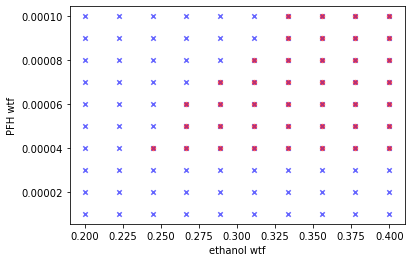

In [7]:
create.graph_canidates(component_dict, wtf_sample_canidates, filtered_wtf_samples)
# add in other information
# log scale/scinot 

In [ ]:
component_volume_lists = create.rearrange(filtered_volume_samples)
protocol = simulate.get_protocol_api('2.0')
ot2_commands.run(protocol, experiment_dict, opentrons_dict, component_volume_lists) # alright cmon wig!

In [ ]:
# label printer - track
